In [485]:
from bs4 import BeautifulSoup
from urllib.request import urlopen
import pandas as pd
import numpy as np
import folium # map rendering library
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import requests # library to handle requests
from wordcloud import WordCloud, STOPWORDS
import matplotlib as mpl
import matplotlib.pyplot as plt
import os.path
import json
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize
import seaborn as sns
# import k-means from clustering stage
from sklearn.cluster import KMeans
import random
#!pip install dataframe-image
import dataframe_image as dfi
from pandas.plotting import table
from pandas.plotting import scatter_matrix
from sklearn import preprocessing

In [39]:

categories=[{'name':'Art','id':'4d4b7104d754a06370d81259'},
            {'name':'Food','id':'4d4b7105d754a06374d81259'},
            {'name':'Nightlife','id':'4d4b7105d754a06376d81259'},
            {'name':'University','id':'4d4b7105d754a06372d81259'},
            {'name':'Events','id':'4d4b7105d754a06373d81259'},
            {'name':'Outdoors & Recreation','id':'4d4b7105d754a06377d81259'},
            {'name':'Professional & Other Places','id':'4d4b7105d754a06375d81259'},
            {'name':'Residence','id':'4e67e38e036454776db1fb3a'},
            {'name':'Shop & Service','id':'4d4b7105d754a06378d81259'},
            {'name':'Travel & Transport','id':'4d4b7105d754a06379d81259'}]
venues_loaded = None
clean_venues = {}
all_venues = {}

cities = [{'name': 'Rome','lat': '41.89193', 'lng' : '12.51133', 'venues': None},
          {'name': 'Berlin','lat': '52.520008', 'lng' : '13.404954', 'venues': None}]
         
for city in cities:
    name=city['name']
    lat=city['lat']
    lng=city['lng']
    all_venues[city['name']] = None
    clean_venues[city['name']] = None
    for category in categories:
        dataframe = None
        venue_names = []
        venues_list = []
        results = []
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                lat,
                lng,
                radius, 
                LIMIT,
                category['id'])
                
        request = requests.get(url).json()['response']['venues']
        dataframe = json_normalize(request)
        dataframe["categories"] = category['name']
        if all_venues[city['name']] is None:
            all_venues[city['name']] = dataframe.copy()
        else:
            all_venues[city['name']] = all_venues[city['name']].append(dataframe.copy())
    city['venues'] = all_venues[city['name']]
    clean_venues[city['name']] = all_venues[city['name']][["id","name","categories","location.postalCode"]]


<ipython-input-39-115df2dca6e6>:65: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  dataframe = json_normalize(request)


In [444]:
for city in cities:
    clean_venues[city['name']].head().to_latex(index=False)
    dfi.export(clean_venues[city['name']].head(), "{}.png".format(city['name']))

In [445]:
#clean_venues["categories"].value_counts()
small_df={}
small_df_dummy={}
for city in cities:
    small_df[city['name']] = clean_venues[city['name']].loc[:, ["location.postalCode","categories"]]
    small_df_dummy[city['name']] = pd.get_dummies(small_df[city['name']]["categories"])
    small_df[city['name']] = pd.concat([small_df[city['name']], small_df_dummy[city['name']]], axis=1)
    small_df[city['name']].drop("categories", axis = 1, inplace=True)
    small_df[city['name']].head()
    dfi.export(small_df[city['name']].head(), "{}_one_hot.png".format(city['name']))

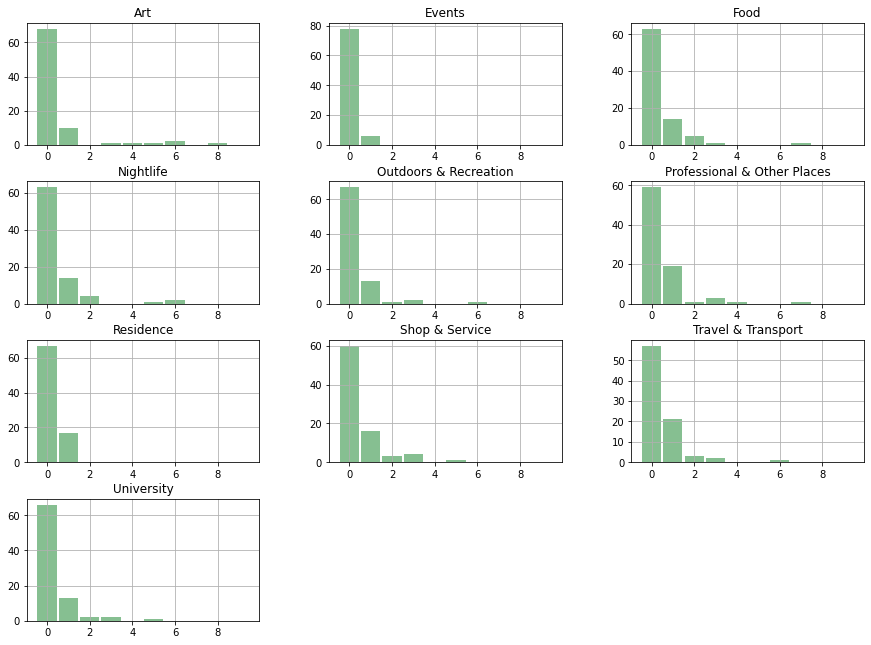

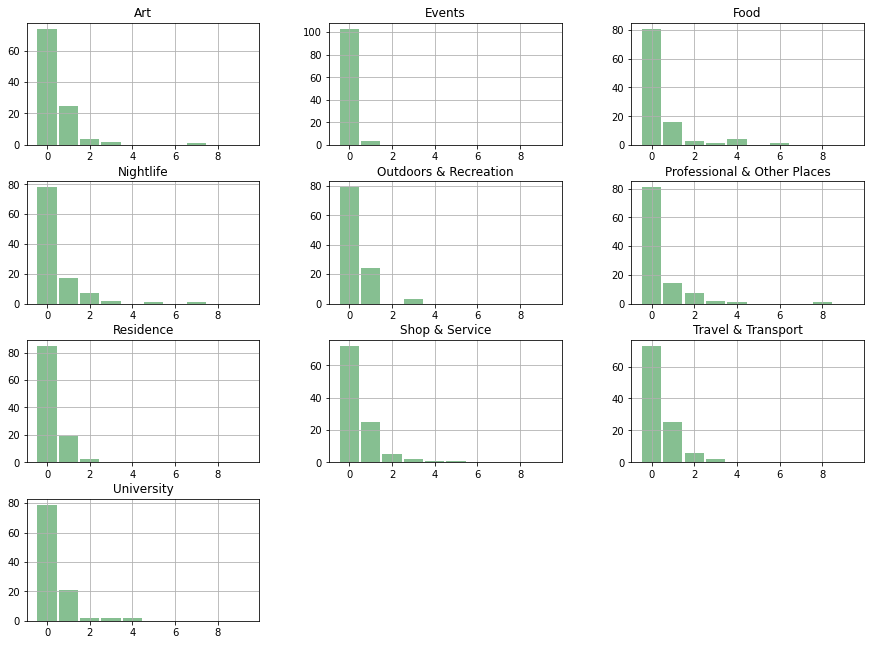

In [457]:
bourhoods={}
for city in cities:
    bourhoods[city['name']] = small_df[city['name']].groupby("location.postalCode").sum().reset_index()
    bourhoods[city['name']].hist(figsize=(15,11), color='#86bf91',rwidth=0.9, bins = 10, range=[0, 10], align='left')


In [484]:
for city in cities:
    print(bourhoods[city['name']]['Art'].value_counts())


0    68
1    10
6     2
3     1
4     1
5     1
8     1
Name: Art, dtype: int64
0    74
1    25
2     4
3     2
7     1
Name: Art, dtype: int64


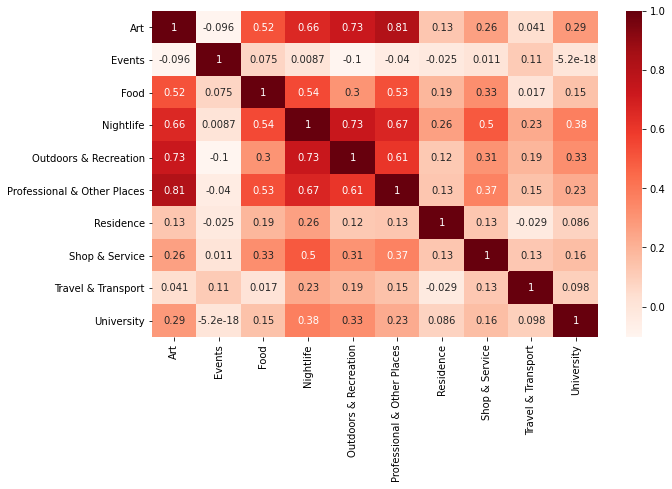

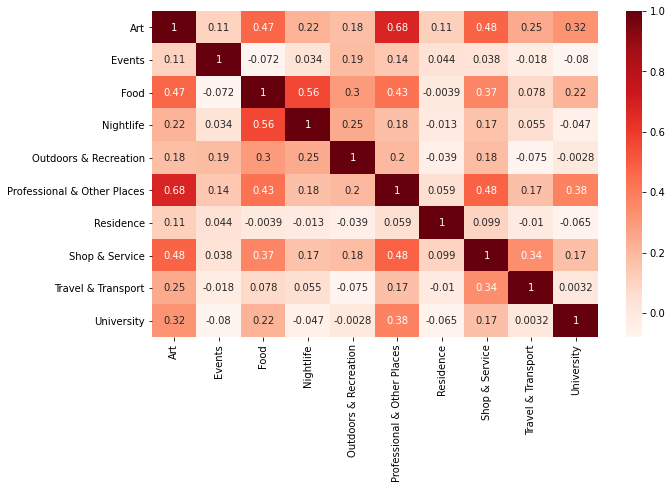

In [478]:
for city in cities:
    plt.figure(figsize=(10,6))
    cor = bourhoods[city['name']].corr()
    sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)

    plt.savefig("{}_category correlation".format(city['name']))

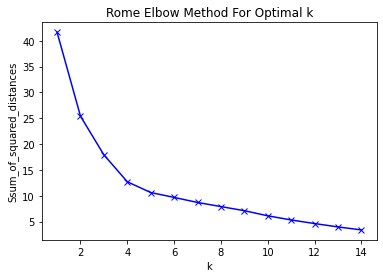

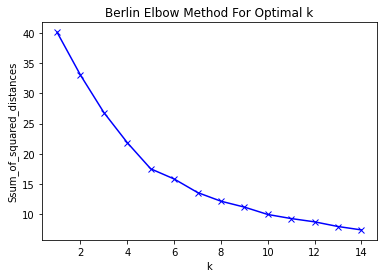

In [494]:
bourhoods_clustering={}
for city in cities:
    bourhoods_clustering[city['name']] = bourhoods[city['name']].drop("location.postalCode", 1)
    x = bourhoods_clustering[city['name']].values 
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    bourhoods_clustering[city['name']] = pd.DataFrame(x_scaled)
    sum_of_squared_distances = []
    K = range(1,15)
    for k in K:
        km = KMeans(n_clusters=k)
        km = km.fit(bourhoods_clustering[city['name']])
        sum_of_squared_distances.append(km.inertia_)

    plt.plot(K, sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Ssum_of_squared_distances')
    plt.title("{} Elbow Method For Optimal k".format(city['name']))
    plt.savefig("{} Elbow Method For Optimal k".format(city['name']))
    plt.show()
    
   

In [487]:
#optimal k=5
km_opt = {}
for city in cities:
    km_opt[city['name']] = KMeans(n_clusters=5).fit(bourhoods_clustering[city['name']])

In [488]:
#bourhoods_clustering[city['name']].insert(0, 'Cluster Labels', km_opt[city['name']].labels_)
for city in cities:
    bourhoods[city['name']].insert(0, 'Cluster Labels', km_opt[city['name']].labels_)

In [490]:
#checking the distirbution among categories
cities_onehot = []
for city in cities:
    if city['venues'] is not None:
        city_onehot = {}
        venues_onehot = pd.get_dummies(city['venues']['categories'], prefix="", prefix_sep="")
        #print(venues_onehot)
        venues_onehot['Neighbourhood'] = city['venues']['location.postalCode']
        #print(venues_onehot)
        venues_onehot = venues_onehot.groupby(['Neighbourhood']).sum().reset_index()
        #print(venues_onehot)
        del venues_onehot['Neighbourhood']
        city_onehot['name'] = city['name']
        city_onehot['venues_one_hot'] = venues_onehot
        cities_onehot.append(city_onehot)
        print(venues_onehot.head())


   Art  Events  Food  Nightlife  Outdoors & Recreation  \
0    0       0     0          0                      0   
1    0       0     0          0                      0   
2    0       0     0          1                      0   
3    0       0     0          0                      0   
4    0       0     1          0                      0   

   Professional & Other Places  Residence  Shop & Service  Travel & Transport  \
0                            0          0               1                   1   
1                            0          0               2                   0   
2                            0          1               0                   0   
3                            0          1               0                   1   
4                            0          0               0                   0   

   University  
0           0  
1           0  
2           0  
3           0  
4           0  
   Art  Events  Food  Nightlife  Outdoors & Recreation  \
0    0    

In [499]:
for city in cities:
    print(bourhoods[city['name']].describe())

       Cluster Labels        Art     Events       Food  Nightlife  \
count       84.000000  84.000000  84.000000  84.000000  84.000000   
mean         2.285714   0.500000   0.071429   0.404762   0.464286   
std          0.938743   1.452045   0.259086   0.970890   1.145409   
min          0.000000   0.000000   0.000000   0.000000   0.000000   
25%          2.000000   0.000000   0.000000   0.000000   0.000000   
50%          2.000000   0.000000   0.000000   0.000000   0.000000   
75%          2.000000   0.000000   0.000000   0.250000   0.250000   
max          4.000000   8.000000   1.000000   7.000000   6.000000   

       Outdoors & Recreation  Professional & Other Places  Residence  \
count              84.000000                    84.000000  84.000000   
mean                0.321429                     0.488095   0.202381   
std                 0.866522                     1.069783   0.404188   
min                 0.000000                     0.000000   0.000000   
25%               

In [491]:
#setting colors for each venue category:
venues_category = []
for c in cities_onehot:
    if c is not None:
        venues_category.extend(c['venues_one_hot'].columns)
        venues_category = list(dict.fromkeys(venues_category)) #removing duplicates
colors_array = cm.rainbow(np.linspace(0, 1, len(venues_category)))
rainbow = {venues_category[i] : colors.rgb2hex(colors_array[i]) for i in range(len(colors_array))}
print(rainbow)

{'Art': '#8000ff', 'Events': '#4856fb', 'Food': '#10a2f0', 'Nightlife': '#2adddd', 'Outdoors & Recreation': '#62fbc4', 'Professional & Other Places': '#9cfba4', 'Residence': '#d4dd80', 'Shop & Service': '#ffa256', 'Travel & Transport': '#ff562c', 'University': '#ff0000'}


                                           x     y
Events                                Events  12.0
Residence                          Residence  34.0
Outdoors & Recreation  Outdoors & Recreation  54.0
University                        University  56.0
Food                                    Food  68.0
624.0


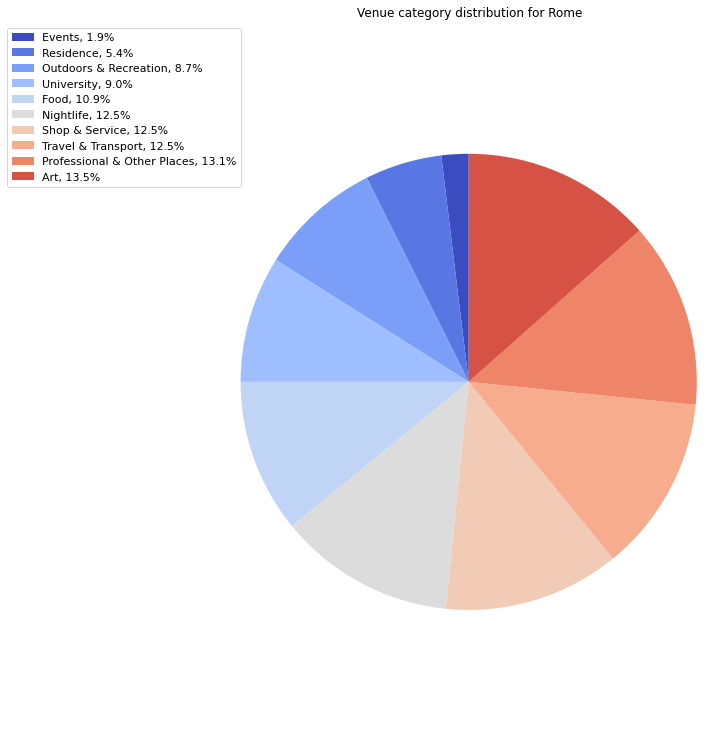

                                           x     y
Events                                Events   6.0
Residence                          Residence  46.0
Outdoors & Recreation  Outdoors & Recreation  66.0
University                        University  78.0
Travel & Transport        Travel & Transport  86.0
758.0


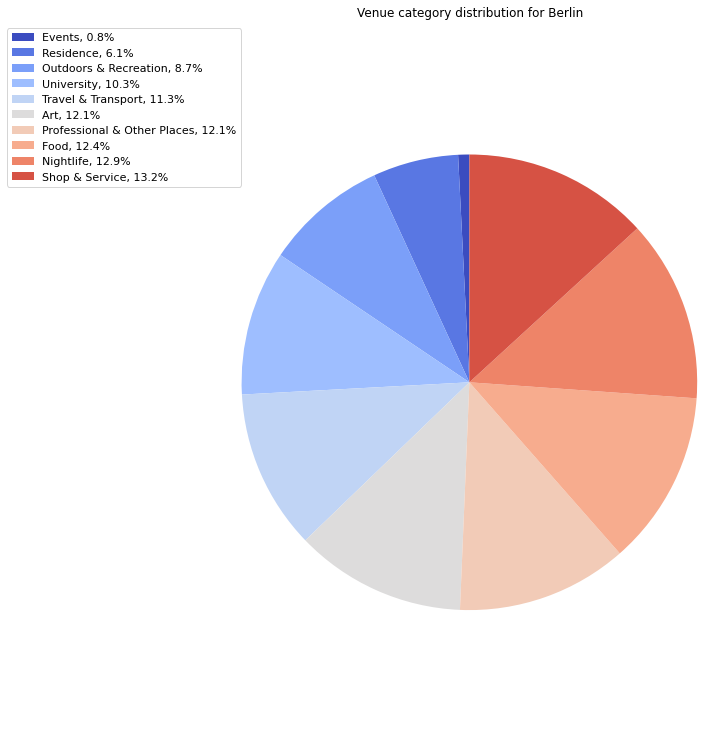

In [495]:
#Venue category analysis
# Generate data on commute times.
#len(cities_onehot)
#print(c)
for c in cities_onehot:
    axes = {}
    c['venues_one_hot'].loc['Total',:]= c['venues_one_hot'].sum(axis=0)
    #print(c['venues_one_hot'].loc['Total',:])
    axes['x'] = c['venues_one_hot'].columns
    axes['y'] = c['venues_one_hot'].loc['Total',:]
    axes_df = pd.DataFrame.from_dict(axes)
    axes_df.sort_values(by=['y'], inplace=True)
    print(axes_df.head())
    sizes = axes_df['y']
    labels = axes_df['x']

    fig1, ax1 = plt.subplots(figsize=(10, 10))
    fig1.subplots_adjust(0.3,0,1,1)


    theme = plt.get_cmap('coolwarm')
    ax1.set_prop_cycle("color", [theme(1. * i / len(sizes)) for i in range(len(sizes))])

    _, _ = ax1.pie(sizes, startangle=90)

    ax1.axis('equal')

    total = sum(sizes)
    print(total)
    plt.legend(
        loc='upper left',
        labels=['%s, %1.1f%%' % (
            l, (float(s) / total) * 100) for l, s in zip(labels, sizes)],
        prop={'size': 11},
        bbox_to_anchor=(0.0, 1),
        bbox_transform=fig1.transFigure
    )
    plt.title("Venue category distribution for {}".format(c['name']))
    plt.savefig("Venue category distribution for {}".format(c['name']))
    plt.show()



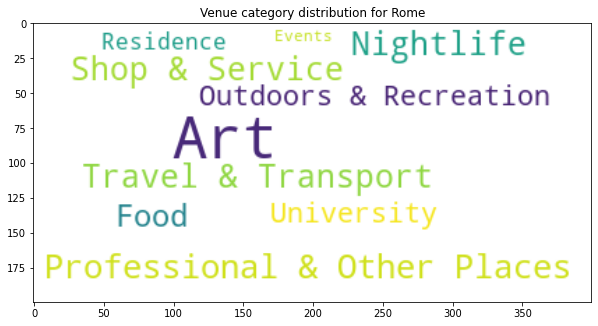

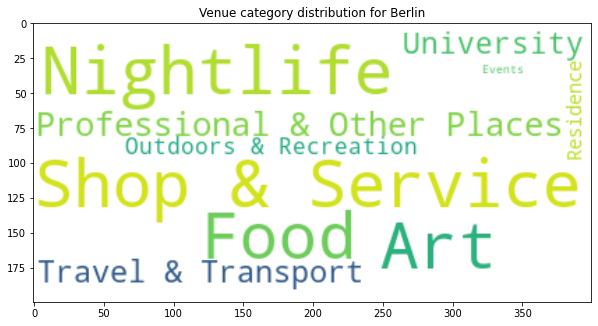

In [91]:
#Visualizing the venues category
for c in cities_onehot:
    total = sum(c['venues_one_hot'].loc['Total',:])
    wordcloud = WordCloud(background_color='white')
    wordcloud.generate_from_frequencies(frequencies=c['venues_one_hot'].loc['Total',:] / total)
    plt.figure(figsize=(10,10))
    plt.title("Venue category distribution for {}".format(c['name']))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.show()

In [240]:
bourhoods_clustering['Berlin'].head()


,Cluster Labels,Art,Events,Food,Nightlife,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport,University
0,0,0,1,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,2,0
2,0,0,0,0,2,0,1,1,1,0,0
3,3,7,0,4,0,0,8,0,4,2,4
4,1,1,0,4,2,1,1,0,1,0,0


In [365]:
#Loading postal_codes coordinates
postal_codes_coordinates = {
    'Berlin': '/Users/vincenzo/Documents/coursera/IBM Data Science Professional Certificate/final_project/capstone_project_repo/berlin_posta_code_coordinates_clean.csv',
    'Rome' : '/Users/vincenzo/Documents/coursera/IBM Data Science Professional Certificate/final_project/capstone_project_repo/italy_postal_code_coordinates.csv'
    
}

coordinates_data = {}
borhoods_coord = {}
df_codes_coord_grouped = {}
df_codes_coord = {}
for city in cities:
    print('city_{}'.format(city['name']))
    coordinates_data[city['name']] = pd.read_csv(postal_codes_coordinates[city['name']],sep=';')
    df_codes_coord[city['name']] = coordinates_data[city['name']].loc[:,['location.postalCode','lat','lng']]
    df_codes_coord_grouped[city['name']] = df_codes_coord[city['name']].groupby('location.postalCode').mean().reset_index()
    df_codes_coord_grouped[city['name']] = df_codes_coord_grouped[city['name']].astype({'location.postalCode': 'str'})
    bourhoods[city['name']] = bourhoods[city['name']].astype({'location.postalCode': 'str'})
    borhoods_coord[city['name']] = pd.merge(df_codes_coord_grouped[city['name']],bourhoods[city['name']],on='location.postalCode')
print(borhoods_coord['Rome'])
print(borhoods_coord['Berlin'])

city_Rome
city_Berlin
   location.postalCode        lat        lng  Cluster Labels  Art  Events  \
0                   10  42.013550  12.783750               2    0       0   
1                   15  42.051600  12.619700               2    0       0   
2                   19  41.966800  12.802371               2    0       0   
3                   40  41.671086  12.589086               2    0       0   
4                   42  41.494600  12.605700               2    0       0   
..                 ...        ...        ...             ...  ...     ...   
76                6123  43.112200  12.388800               2    1       0   
77                6124  43.112200  12.388800               2    0       0   
78                6125  43.112200  12.388800               2    0       0   
79                6134  43.112200  12.388800               2    0       0   
80               67051  42.045733  13.433417               2    1       0   

    Food  Nightlife  Outdoors & Recreation  Professio

In [360]:
rnd = np.round(np.random.uniform(0.010203, 0.011908, size=(len(borhoods_coord['Rome'].loc[:,['lat']]), 1)), 6)
borhoods_coord['Rome'].loc[:,['lat']] = borhoods_coord['Rome'].loc[:,['lat']] + rnd
rnd = np.round(np.random.uniform(0.010403, 0.011408, size=(len(borhoods_coord['Rome'].loc[:,['lat']]), 1)), 6)
borhoods_coord['Rome'].loc[:,['lng']] = borhoods_coord['Rome'].loc[:,['lng']] + rnd

In [255]:
cluster_category = []
colors_array = {}
rainbow = {}
for city in cities:
    labels =borhoods_coord[city['name']]['Cluster Labels'].unique()
    colors_array[city['name']] = cm.rainbow(np.linspace(0, 1, len(labels)))
    rainbow[city['name']] = {labels[i] : colors.rgb2hex(colors_array[city['name']][i]) for i in range(len(colors_array[city['name']]))}
print(rainbow)

{'Rome': {2: '#8000ff', 0: '#00b5eb', 1: '#80ffb4', 3: '#ffb360', 4: '#ff0000'}, 'Berlin': {0: '#8000ff', 3: '#00b5eb', 1: '#80ffb4', 4: '#ffb360', 2: '#ff0000'}}


In [366]:
#visualizing on the map
geojson = {'Berlin' : 'https://raw.githubusercontent.com/ljwolf/geopython/master/data/berlin-neighbourhoods.geojson',
          'Rome' : 'https://app.geonue.com/geoserver/geonue/limiti_municipiroma/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=limiti_municipiroma&maxfeatures=2000&outputformat=application%2Fjson&srsName=EPSG:4326'}

population_dist = {'Berlin' : 'https://raw.githubusercontent.com/vscoca/Coursera_Capstone/main/berlin_population.csv',
                  'Rome' : 'https://raw.githubusercontent.com/vscoca/Coursera_Capstone/main/berlin_population.csv'}

city_maps={}
for c in cities:
    city_map = folium.Map(location=[c['lat'], c['lng']], zoom_start=15)
    if borhoods_coord[c['name']] is not None:
        print('City {}'.format(c['name']))
        for index, row in borhoods_coord[c['name']].iterrows():
            print('Bourhood: {}, ({},{}), {}'.format(row['location.postalCode'],row['lat'],row['lng'],row['Cluster Labels']))
            folium.CircleMarker(
                [row['lat'], row['lng']],
                radius=10,
                popup='Name: {} - Cluster Labels: {}'.format(row['location.postalCode'],row['Cluster Labels']),
                color=rainbow[c['name']][row['Cluster Labels']],
                fill=True,
                fill_opacity=0.7).add_to(city_map)
    city_maps[c['name']] = city_map
#print(city_aps)

City Rome
Bourhood: 10, (42.01355,12.78375), 2
Bourhood: 15, (42.0516,12.6197), 2
Bourhood: 19, (41.9668,12.80237142857143), 2
Bourhood: 40, (41.67108571428572,12.589085714285714), 2
Bourhood: 42, (41.4946,12.6057), 2
Bourhood: 49, (41.6857,12.7775), 2
Bourhood: 54, (41.84932,12.223900000000002), 0
Bourhood: 55, (41.93833333333333,12.0984), 2
Bourhood: 60, (42.144788,12.437308), 2
Bourhood: 119, (41.8919,12.5113), 2
Bourhood: 120, (41.8919,12.5113), 1
Bourhood: 121, (41.812,12.3939), 2
Bourhood: 123, (41.970333333333336,12.429133333333333), 2
Bourhood: 124, (41.8202,12.429300000000001), 2
Bourhood: 128, (41.783640000000005,12.45832), 2
Bourhood: 133, (41.866074999999995,12.589625000000002), 2
Bourhood: 135, (41.9376,12.455666666666666), 2
Bourhood: 136, (41.8919,12.5113), 2
Bourhood: 137, (41.8919,12.5113), 0
Bourhood: 139, (41.8919,12.5113), 0
Bourhood: 141, (41.8919,12.5113), 2
Bourhood: 143, (41.854299999999995,12.4973), 0
Bourhood: 144, (41.8919,12.5113), 0
Bourhood: 146, (41.8919,

In [367]:
city_maps['Rome']

In [496]:
city_maps['Berlin']

In [417]:
bourhoods_cluster = {}
cluster_maps = {}
for c in cities:
    if borhoods_coord[c['name']] is not None:
        bourhoods_cluster[c['name']] = None
        n_cluster = len(borhoods_coord[c['name']]['Cluster Labels'].unique())
        for i in range(1,n_cluster):
            city_map = folium.Map(location=[c['lat'], c['lng']], zoom_start=15)
            for index, row in borhoods_coord[c['name']].loc[borhoods_coord[c['name']]['Cluster Labels'] == i].iterrows():
                folium.CircleMarker(
                    [row['lat'], row['lng']],
                    radius=10,
                    popup='Name: {} - Cluster Labels: {}'.format(row['location.postalCode'],row['Cluster Labels']),
                    color=rainbow[c['name']][row['Cluster Labels']],
                    fill=True,
                    fill_opacity=0.7).add_to(city_map)
            if bourhoods_cluster[c['name']] is None:
                bourhoods_cluster[c['name']] = [city_map]
            else:
                bourhoods_cluster[c['name']].append(city_map)
            m.save('{}_{}.html'.format(c['name'],i))
        

In [ ]:
        city_map = folium.Map(location=[c['lat'], c['lng']], zoom_start=15)
        print('City {}'.format(c['name']))
        for index, row in borhoods_coord[c['name']].iterrows():
            print('Bourhood: {}, ({},{}), {}'.format(row['location.postalCode'],row['lat'],row['lng'],row['Cluster Labels']))
            folium.CircleMarker(
                [row['lat'], row['lng']],
                radius=10,
                popup='Name: {} - Cluster Labels: {}'.format(row['location.postalCode'],row['Cluster Labels']),
                color=rainbow[c['name']][row['Cluster Labels']],
                fill=True,
                fill_opacity=0.7).add_to(city_map)
    city_maps[c['name']] = city_map
#print(cit_maps)